In [12]:
# https://adamj.eu/tech/2019/03/11/pip-install-from-a-git-repository/
# Install customized linc-detector faster-rcnn
!pip install --upgrade --force-reinstall git+https://github.com/linc-lion/LINC-detector.git@d8ed6ddfce855fbf6b9a8f081a777a1d6d940fb6

  Cloning https://github.com/linc-lion/LINC-detector.git (to revision d8ed6ddfce855fbf6b9a8f081a777a1d6d940fb6) to /private/var/folders/gj/d1dhz4yj7qg61hcmnsqs8mhc0000gn/T/pip-req-build-g5mog2_k
  Running command git clone --filter=blob:none --quiet https://github.com/linc-lion/LINC-detector.git /private/var/folders/gj/d1dhz4yj7qg61hcmnsqs8mhc0000gn/T/pip-req-build-g5mog2_k
  Running command git rev-parse -q --verify 'sha^d8ed6ddfce855fbf6b9a8f081a777a1d6d940fb6'
  Running command git fetch -q https://github.com/linc-lion/LINC-detector.git d8ed6ddfce855fbf6b9a8f081a777a1d6d940fb6
  Running command git checkout -q d8ed6ddfce855fbf6b9a8f081a777a1d6d940fb6
  Resolved https://github.com/linc-lion/LINC-detector.git to commit d8ed6ddfce855fbf6b9a8f081a777a1d6d940fb6
  Preparing metadata (setup.py) ... done
  Using cached tensorflow-2.10.0-cp38-cp38-macosx_10_14_x86_64.whl (241.2 MB)
  Using cached numpy-1.23.3-cp38-cp38-macosx_10_9_x86_64.whl (18.1 MB)
  Using cached torch-1.10.1-cp38-none-m

In [18]:
import torchvision

draw_confidence_threshold = 0.5

to_tensor = torchvision.transforms.ToTensor()
convert_to_pil = torchvision.transforms.ToPILImage()

In [22]:
from linc.detector.helper.utils import draw_boxes
import time
from linc.detector.models import detection
import PIL.Image
import torch


@torch.no_grad()
def predict(image_path, model_path, cpu):
    device = 'cuda' if torch.has_cuda and not cpu else 'cpu'
    print(f"Running inference on {device} device")

    print('Loading image... ', end='', flush=True)
    loaded_image = PIL.Image.open(image_path)
    width, height = loaded_image.size
    print(f'Input image_width: {width}, image_height: {height}')
    image = to_tensor(loaded_image).to(device)
    print('Done.')

    print('Loading checkpoint from hardrive... ', end='', flush=True)
    checkpoint = torch.load(model_path, map_location=device)
    label_names = checkpoint['label_names']
    print('Done.')

    print('Building model and loading checkpoint into it... ', end='', flush=True)
    model = detection.fasterrcnn_resnet50_fpn(
        num_classes=len(label_names) + 1, pretrained_backbone=False
    )
    model.to(device)

    model.load_state_dict(checkpoint['model'])
    model.eval()
    print('Done.')

    print('Running image through model... ', end='', flush=True)
    tic = time.time()
    outputs = model([image])
    toc = time.time()
    print(f'Done in {toc - tic:.2f} seconds!')

    scores = outputs[0]['scores']
    top_scores_filter = scores > draw_confidence_threshold
    top_scores = scores[top_scores_filter]
    top_boxes = outputs[0]['boxes'][top_scores_filter]
    top_labels = outputs[0]['labels'][top_scores_filter]
    if len(top_scores) > 0:
        image_with_boxes = draw_boxes(
            image.cpu(), top_boxes, top_labels.cpu(), label_names, scores, vert_size=500
        )
    else:
        print("The model didn't find any object it feels confident about enough to show")
        exit()
    pil_picture = convert_to_pil(image_with_boxes)
    width, height = loaded_image.size
    print(f'Predicted image_width: {width}, image_height: {height}')

    return pil_picture

Running inference on cpu device
Loading image... Input image_width: 5184, image_height: 3456
Done.
Loading checkpoint from hardrive... Done.
Building model and loading checkpoint into it... Done.
Running image through model... Done in 5.14 seconds!
Predicted image_width: 5184, image_height: 3456
Displaying predicted image ... 

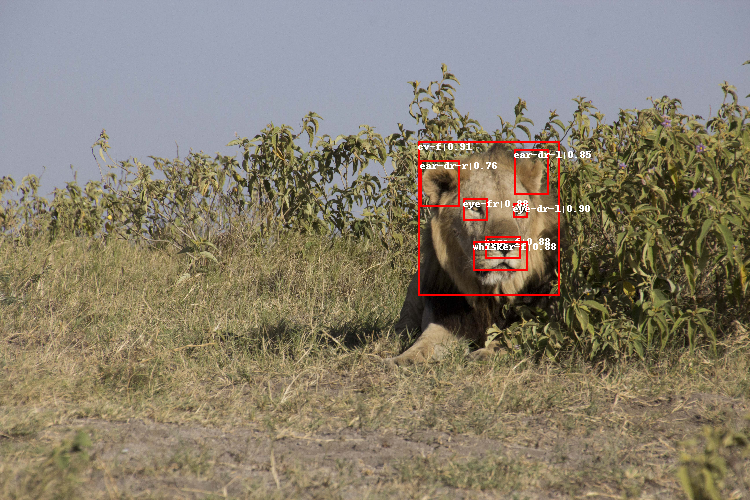

In [31]:
from IPython.display import display

model_path = '../runs/Oct02_18-37-40_pytorch-1-10-cpu-p-ml-g4dn-2xlarge-a95c82100b2ed0e7e4d92d59e530/model_finished.pth'
input_image_path = '../datasets/evaluation/Amboga/IMG_8590.jpg'
output_image_path = '../datasets/evaluation/predictions/IMG_8590_predicted.jpg'
predicted_picture = predict(input_image_path, model_path, 'cpu')

# print(f'Saving image to {output_image_path}... ', end='', flush=True)
# predicted_picture.save(output_image_path)

print('Displaying predicted image ... ', end='', flush=True)
display(predicted_picture)